In [1]:
from gptopt.optim.attn_kq import * 
from utils_pdhg import *
from gptopt.optim.least_squares_torchmin import * 

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )  
\end{aligned}
$$


In [3]:
n_layer = 4
std1 = 0.02 / np.sqrt(2.0 * n_layer)
std2 = 0.01
rank_ratio = 0.7
max_iter = 1000

betas = [ 1e-3, 5e-4, 1e-4]

#  $m=n=75$

In [4]:
m = n = 75

A2, A1, G1, G2, A2_np, A1_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=1, std2=1, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.05

A_linop = attn_linop_from_matrices(A1, A2)
Grad = torch.cat([G1, G2], dim=0)
lamb_max = A_linop.fro_norm 
mu_reg = 0 

print(f"{lamb_max=:.4e}")

lamb_max=1.0605e+02


In [5]:
Z_star1, Z_star2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A2_np, A1_np, beta, mu=mu_reg, verbose=False)
Z_star_torch = torch.tensor(np.concatenate([Z_star1, Z_star2], axis=0), dtype=A1.dtype, device=device)
Y_star_torch = torch.tensor(Y_star, dtype=A1.dtype, device=device)

In [6]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

In [7]:
func_obj = lambda Z: (Grad * Z).sum().item()  
func_constr_viol = lambda Z: max(torch.max(torch.abs(A_linop.mv(Z))).item() - beta, 0) / beta

In [8]:
print(
    f"{f_star=:.4e}, "
    f"{func_obj(Z_star_torch)}, "
    f"\ncvxpy constraint violation: "
    f"{func_constr_viol(Z_star_torch)}"
) 

pd_residuals_max_ball_linop(A_linop, Y_star_torch, Z_star_torch, Grad, beta, mu_reg)

f_star=-3.7663e+00, -3.7662649154663086, 
cvxpy constraint violation: 7.599592208307193e-07


(1.7605721950531006e-05,
 4.694859186808268e-06,
 1.5115667792997556e-06,
 9.72879162489571e-08)

In [9]:
residuals_cold_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta=beta, 
                                                 mu_reg=mu_reg, f_star=f_star, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

Y0, res_lsmr_y, itn_y = solve_lsmr_Y_lstsq(A_linop, Grad)
Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0)

print(f"{res_lsmr_y=:.4e}, {res_lsmr_z=:.4e}, {itn_y=}, {itn_z=}")
r1, r1_rel, r2, r2_rel = pd_residuals_max_ball_linop(A_linop, Y0, Z0, Grad, beta, mu_reg)
print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}")   

residuals_warm_start = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, 
                                        Z0=Z0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=f_star, stopping=False, max_iter=max_iter, eps_abs=1e-5)

Method                 Obj          Viol
----------------------------------------
pdhg          -3.761137e+00  1.546565e-01
rehpdhg       -3.877092e+00  1.141979e-01
pdhg ds       -3.765071e+00  9.753132e-02
rehpdhg ds    -3.861081e+00  8.945318e-02
ada rehpdhg   -3.762435e+00  8.739397e-03
ada rehpdhg ds  -3.764074e+00  9.424552e-03
res_lsmr_y=2.0754e-05, res_lsmr_z=5.1273e-05, itn_y=260, itn_z=440
init r1_rel=2.0000e+00, r2_rel=2.0754e-05
Method                 Obj          Viol
----------------------------------------
init          3.766267e+00  3.804415e-04
pdhg          -3.750880e+00  1.542296e-01
rehpdhg       -3.750597e+00  2.929518e-02
pdhg ds       -3.760857e+00  1.139089e-01
rehpdhg ds    -3.758215e+00  1.240814e-02
ada rehpdhg   -3.748520e+00  9.749547e-03
ada rehpdhg ds  -3.755086e+00  1.143152e-02


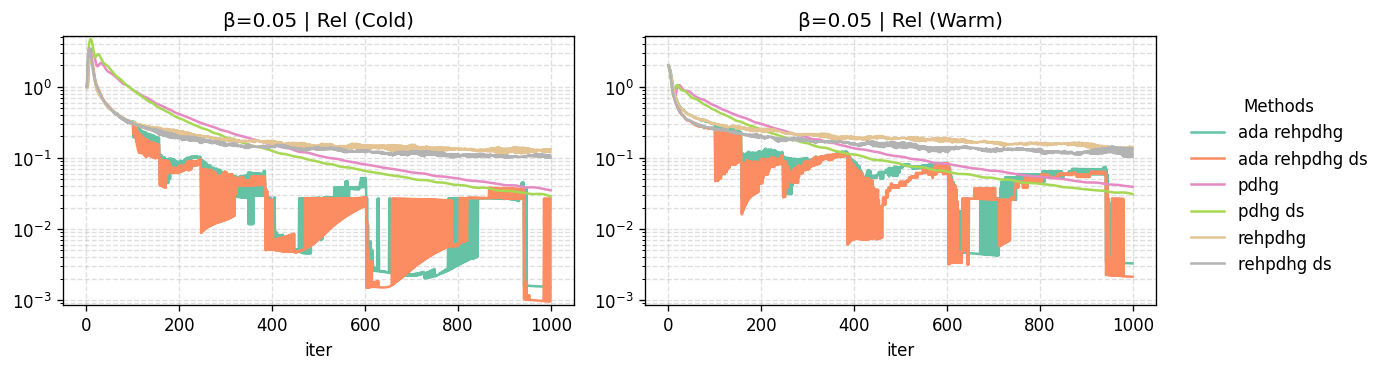

In [10]:
_ = plot_residuals_cold_warm_grid_by_param(
    {beta:residuals_cold_start},
    {beta:residuals_warm_start},
    param_name="beta", 
    dpi=120, 
)

#  $m=n=1000$

In [11]:
m = n = 1000
std2 = 1 
rank_ratio = 0.5 
A2, A1, G1, G2, A2_np, A1_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.05

A_linop = attn_linop_from_matrices(A1, A2)
Grad = torch.cat([G1, G2], dim=0)
lamb_max = A_linop.fro_norm 

print(f"{lamb_max=:.4e}")

lamb_max=1.0007e+01


In [12]:
residuals_cold_start, residuals_warm_start = {}, {}
lsmr_maxiter = 200
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta=beta, 
                                                 mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, res_lsmr_y, itn_y = solve_lsmr_Y_lstsq(A_linop, Grad, maxiter=lsmr_maxiter)
    Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0, maxiter=lsmr_maxiter)

    print(f"{res_lsmr_y=:.4e}, {res_lsmr_z=:.4e}, {itn_y=}, {itn_z=}")
    r1, r1_rel, r2, r2_rel = pd_residuals_max_ball_linop(A_linop, Y0, Z0, Grad, beta, mu_reg)
    print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}") 

    residuals_warm_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, 
                                        Z0=Z0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5)

beta=0.001, lamb_max=1.0007e+01
Method                 Obj          Viol
----------------------------------------
pdhg          -9.730918e-01  4.148896e-01
rehpdhg       -9.806455e-01  6.164860e-02
pdhg ds       -9.849759e-01  3.711535e-01
rehpdhg ds    -9.931807e-01  6.012297e-02
ada rehpdhg   -9.642490e-01  5.802726e-02
ada rehpdhg ds  -9.767850e-01  5.132046e-02
res_lsmr_y=1.2535e-04, res_lsmr_z=6.5329e-03, itn_y=200, itn_z=200
init r1_rel=1.9999e+00, r2_rel=1.2535e-04
Method                 Obj          Viol
----------------------------------------
init          1.000300e+00  4.258710e-02
pdhg          -9.025315e-01  4.414447e-01
rehpdhg       -8.894432e-01  9.824259e-02
pdhg ds       -9.454891e-01  4.919167e-01
rehpdhg ds    -9.355249e-01  8.809129e-02
ada rehpdhg   -8.458593e-01  8.433317e-02
ada rehpdhg ds  -9.000382e-01  8.085643e-02
beta=0.0005, lamb_max=1.0007e+01
Method                 Obj          Viol
----------------------------------------
pdhg          -4.933555e-01  7.

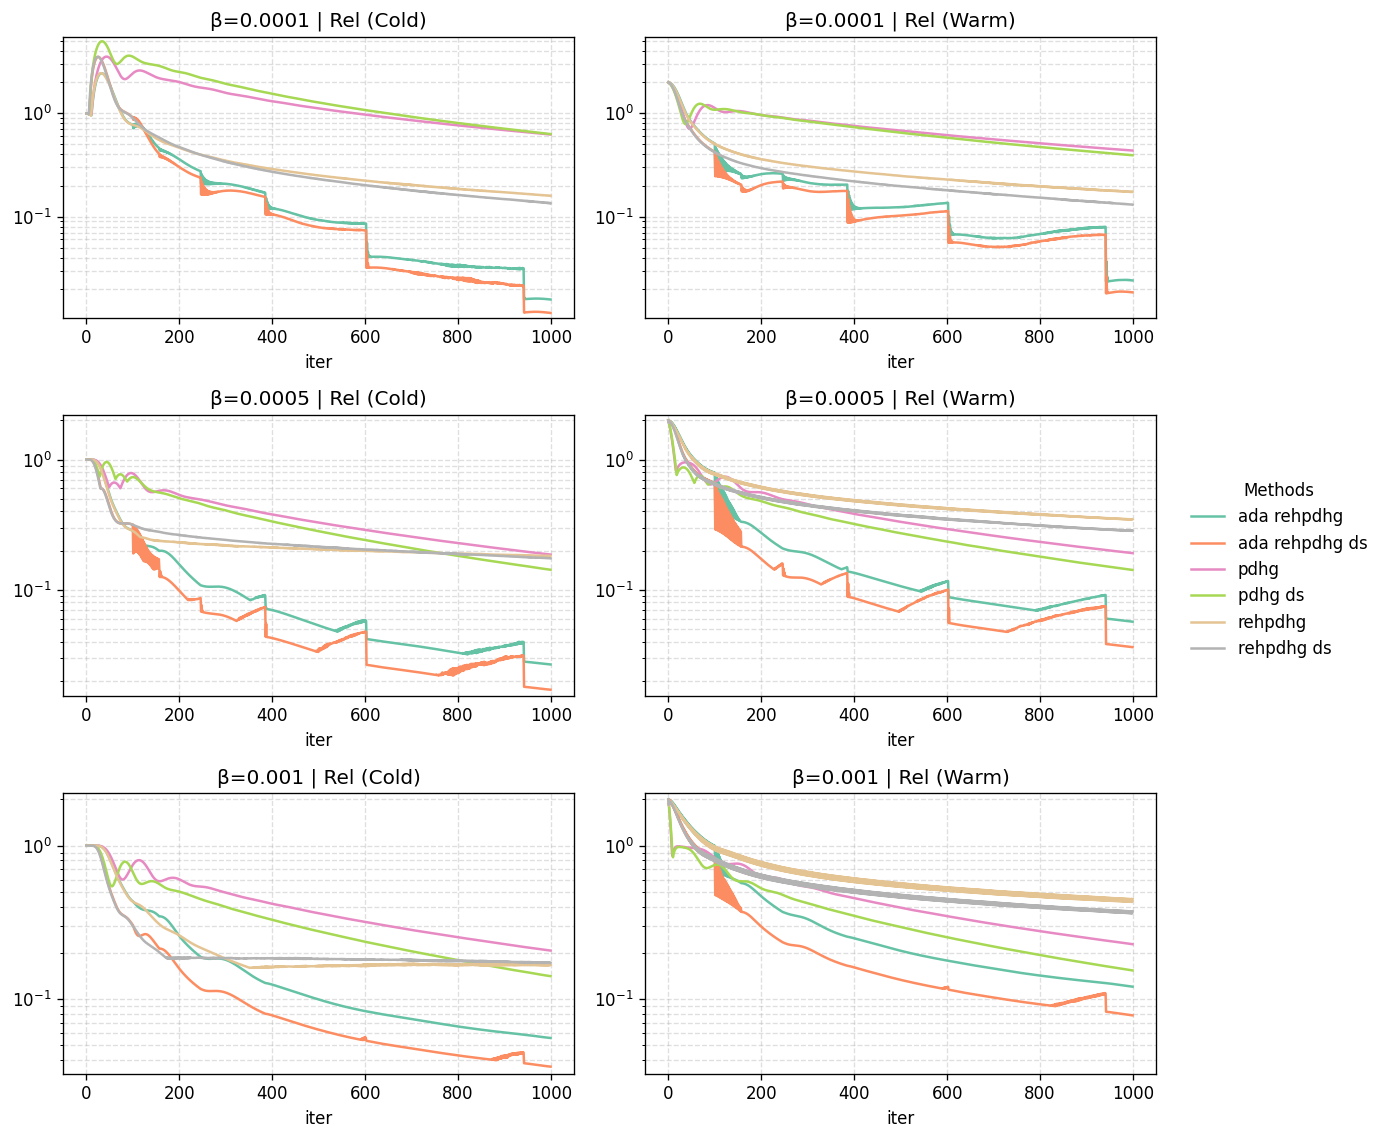

In [13]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)

#  $m=n=1000$

In [14]:
m = n = 1000
std2 = 0.1
rank_ratio = 0.5
A2, A1, G1, G2, A2_np, A1_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                                                 rank_ratio=rank_ratio, G_in_range=True)
beta = 0.05

A_linop = attn_linop_from_matrices(A1, A2)
Grad = torch.cat([G1, G2], dim=0)
lamb_max = A_linop.fro_norm 

print(f"{mu_reg=:.4e}, {lamb_max=:.4e}")

mu_reg=0.0000e+00, lamb_max=9.9973e+00


In [15]:
residuals_cold_start, residuals_warm_start = {}, {}
lsmr_maxiter = 200
for beta in betas:
    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    mu_reg = 0
    print(f"{beta=}, {lamb_max=:.4e}") 
    residuals_cold_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, beta=beta, 
                                                 mu_reg=mu_reg, f_star=None, 
                            stopping=False, max_iter=max_iter, eps_abs=1e-5)

    Y0, res_lsmr_y, itn_y = solve_lsmr_Y_lstsq(A_linop, Grad, maxiter=lsmr_maxiter)
    Z0, res_lsmr_z, itn_z = solve_lsmr_Z_lstsq(A_linop, beta, Y0, maxiter=lsmr_maxiter)

    print(f"{res_lsmr_y=:.4e}, {res_lsmr_z=:.4e}, {itn_y=}, {itn_z=}")
    r1, r1_rel, r2, r2_rel = pd_residuals_max_ball_linop(A_linop, Y0, Z0, Grad, beta, mu_reg)
    print(f"init {r1_rel=:.4e}, {r2_rel=:.4e}") 

    residuals_warm_start[beta] = compare_methods_fast_pdhg(prox_h_conj, h_conj, A_linop, Grad, 
                                        Z0=Z0, Y0=Y0,
                                        beta=beta, mu_reg=mu_reg, f_star=None, stopping=False, max_iter=max_iter, eps_abs=1e-5)

beta=0.001, lamb_max=9.9973e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -7.855155e-02  9.530124e-02
rehpdhg       -7.860185e-02  3.835983e-02
pdhg ds       -8.685040e-02  9.612802e-02
rehpdhg ds    -8.693184e-02  4.146474e-02
ada rehpdhg   -5.967643e-02  2.535798e-02
ada rehpdhg ds  -7.563310e-02  1.912697e-02
res_lsmr_y=1.2986e-04, res_lsmr_z=6.3359e-03, itn_y=200, itn_z=200
init r1_rel=1.9993e+00, r2_rel=1.2986e-04
Method                 Obj          Viol
----------------------------------------
init          1.000312e-01  4.392343e-02
pdhg          -1.985453e-02  1.210437e-01
rehpdhg       -1.965726e-02  4.946131e-02
pdhg ds       -4.924646e-02  1.140374e-01
rehpdhg ds    -4.871850e-02  4.339444e-02
ada rehpdhg   6.142494e-02  7.653236e-05
ada rehpdhg ds  3.357826e-02  3.177840e-02
beta=0.0005, lamb_max=9.9973e+00
Method                 Obj          Viol
----------------------------------------
pdhg          -4.412984e-02  1.31

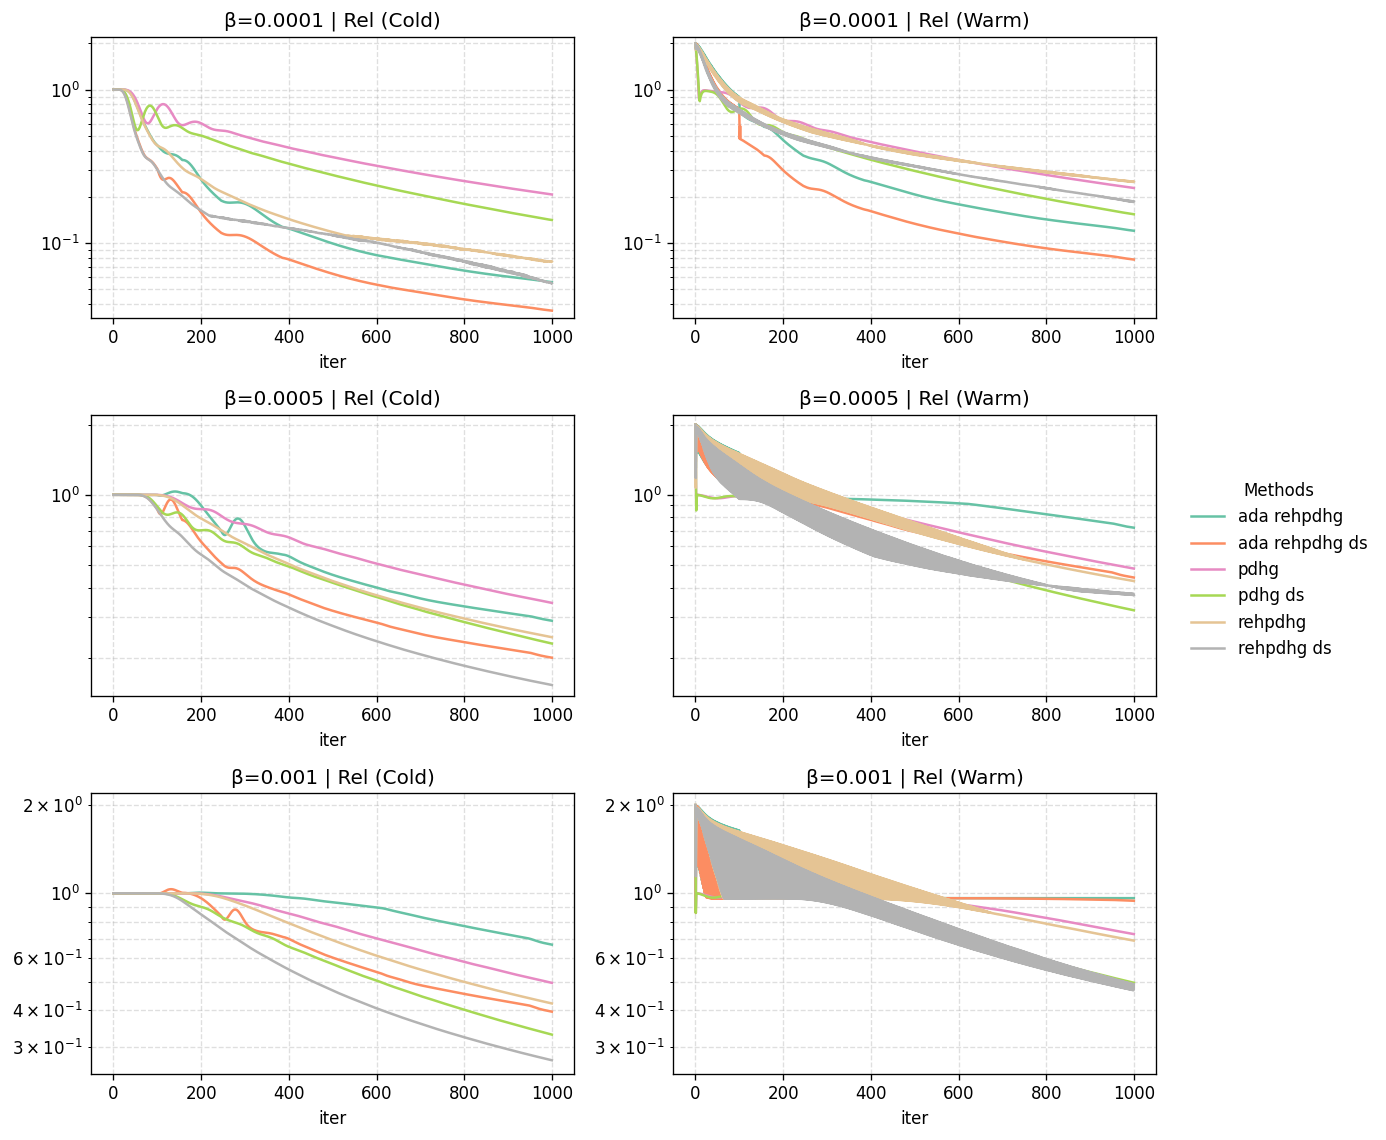

In [16]:
_ = plot_residuals_cold_warm_grid_by_param(
    residuals_cold_start,
    residuals_warm_start,
    param_name="beta", 
    dpi=120, 
)